## LSA & LDA 

___(With stop words)___

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', -1)

_________________________________________________

#### Import pickled stop words from `Effects of Stop Words Elimination for Arabic Information Retrieval: A Comparative Study`

In [3]:
stop_words_df = pd.read_pickle('/home/jovyan/capstone-52/topic_modeling_experiments/pickled_stopwords/comp_study_stopwords.p')

In [4]:
stop_words_df.columns = ["stop_words"]

In [5]:
stop_words_df.columns

Index(['stop_words'], dtype='object')

In [6]:
iabuelkhair_stopwords = stop_words_df['stop_words'].tolist()

In [7]:
iabuelkhair_stopwords[:4]

['انها', 'اثناء', 'اجل', 'احدا']

### Access corpus through pickled MongoDB file

In [8]:
cd ../../Pickled_from_mongo/

/home/jovyan/capstone-52/Pickled_from_mongo


In [9]:
df = pd.read_pickle('../Pickled_from_mongo/combined_eg_gulf_200k_sample.p')

In [10]:
df.head(3)

,_id,cleaned_geo,cleaned_name,cleaned_text,class
0,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكره واللي أحنا فيه دلوقت كمان ح يفوت علينا ولا ندري,EG
1,5a2c7a44204c9e0400cdc0e3,Egypt,agabdelrehim,هي آراء آه بس أزاي أجويرو منتهي يعني أمال لو مكنش الهداف التاريخي للسيتي و كل موسم اقل عدد من الاهداف…,EG
2,5a2c7a44204c9e0400cdc0e4,None,ElsndubadE,أنت صيني أزاي تقارن شادي بالخطيب ألي هو الوحيد ألي خد الكورة الذهبية من مصر وبشهادت الزملكاوي قبل الأ…,EG


In [11]:
df = df.drop(['_id', 'cleaned_geo', 'cleaned_name'], axis=1)

In [14]:
df = df.drop_duplicates(['cleaned_text'], keep=False)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179632 entries, 0 to 95683
Data columns (total 2 columns):
cleaned_text    179632 non-null object
class           179632 non-null object
dtypes: object(2)
memory usage: 4.1+ MB


## Benchmark LSA with stop words

### Label Encode the Categories


In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
le = LabelEncoder()
df['class_numerical'] = le.fit_transform(df['class'])

### TFIDF

### Prepare Document Term Matrix


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
tfidf_vectorizer = TfidfVectorizer(min_df = 1, stop_words= iabuelkhair_stopwords)

In [20]:
document_term_matrix_sps = tfidf_vectorizer.fit_transform(df.cleaned_text)

In [21]:
document_term_matrix_sps


<179632x218701 sparse matrix of type '<class 'numpy.float64'>'
	with 1366041 stored elements in Compressed Sparse Row format>

### Compute SVD of Document Term Matrix

In [24]:
from sklearn.decomposition import TruncatedSVD

In [25]:
n_components = 50
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

In [26]:
svd_matrix = SVD.fit_transform(document_term_matrix_sps)

In [27]:
SVD.explained_variance_ratio_

array([ 0.00214205,  0.00247348,  0.00229391,  0.00199443,  0.00186785,
        0.00171522,  0.0015905 ,  0.00148238,  0.00135054,  0.00123149,
        0.00122168,  0.00117116,  0.00109812,  0.00103643,  0.00101351,
        0.00099886,  0.00095942,  0.00089476,  0.00088403,  0.00087113,
        0.00085381,  0.00085049,  0.00083772,  0.00083096,  0.00080576,
        0.00078784,  0.00078725,  0.00076711,  0.00075666,  0.00075776,
        0.0007364 ,  0.00072796,  0.00071557,  0.0007174 ,  0.00069832,
        0.0006781 ,  0.00066695,  0.00066429,  0.00065476,  0.00065393,
        0.00063403,  0.00062297,  0.00061141,  0.00060386,  0.00059727,
        0.00058227,  0.000579  ,  0.0005683 ,  0.00056274,  0.00054987])

In [28]:
svd_matrix.shape

(179632, 50)

### Load SVD Matrix with Documents and Labels


In [27]:
latent_semantic_analysis = pd.DataFrame(svd_matrix,
                                        index=df.index,
                                        columns=component_names)
latent_semantic_analysis['cleaned_text'] = df.cleaned_text
latent_semantic_analysis['class'] = df['class']

In [30]:
latent_semantic_analysis.head()


,component_1,component_2,cleaned_text,class
0,0.040851,-0.013632,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكره واللي أحنا فيه دلوقت كمان ح يفوت علينا ولا ندري,EG
1,0.040925,-0.027291,هي آراء آه بس أزاي أجويرو منتهي يعني أمال لو مكنش الهداف التاريخي للسيتي و كل موسم اقل عدد من الاهداف…,EG
2,0.006369,-0.001625,أنت صيني أزاي تقارن شادي بالخطيب ألي هو الوحيد ألي خد الكورة الذهبية من مصر وبشهادت الزملكاوي قبل الأ…,EG
3,0.020012,-0.007794,أزاي الناس كانت بتغرد في الخمسينات قبل إختراع تويتر,EG
4,0.067496,-0.044303,التوينز اللي معاها كل الحلو والوحش والمصايب والاكل والفشل مش عارفه من غيرك كنت هعيش أزاي ربنا يخليكي ليا ومش تويته توصفك,EG


In [32]:
vocabulary_loadings = pd.DataFrame(SVD.components_,
                                   index=component_names,
                                   columns=tfidf_vectorizer.get_feature_names()).T

In [33]:
vocabulary_loadings['abs_component_1'] = np.abs(vocabulary_loadings.component_1)
vocabulary_loadings['abs_component_2'] = np.abs(vocabulary_loadings.component_2)

### Display Top Terms for Each Component

In [34]:
vocabulary_loadings.sort_values('abs_component_1',ascending=False).head(10)

,component_1,component_2,abs_component_1,abs_component_2
لا,0.518308,0.105882,0.518308,0.105882
الله,0.369124,0.829093,0.369124,0.829093
مش,0.320755,-0.257180,0.320755,0.257180
والله,0.276075,-0.200997,0.276075,0.200997
كدا,0.264343,-0.207582,0.264343,0.207582
بس,0.243458,-0.167986,0.243458,0.167986
ولا,0.186145,-0.050867,0.186145,0.050867
ايه,0.179963,-0.155853,0.179963,0.155853
اللي,0.162563,-0.098702,0.162563,0.098702
ده,0.134121,-0.090823,0.134121,0.090823


In [35]:
vocabulary_loadings.sort_values('abs_component_2',ascending=False).head(10)

,component_1,component_2,abs_component_1,abs_component_2
الله,0.369124,0.829093,0.369124,0.829093
مش,0.320755,-0.257180,0.320755,0.257180
كدا,0.264343,-0.207582,0.264343,0.207582
والله,0.276075,-0.200997,0.276075,0.200997
بس,0.243458,-0.167986,0.243458,0.167986
ايه,0.179963,-0.155853,0.179963,0.155853
لا,0.518308,0.105882,0.518308,0.105882
شاء,0.044677,0.102145,0.044677,0.102145
اللي,0.162563,-0.098702,0.162563,0.098702
ده,0.134121,-0.090823,0.134121,0.090823


(-0.5, 1)

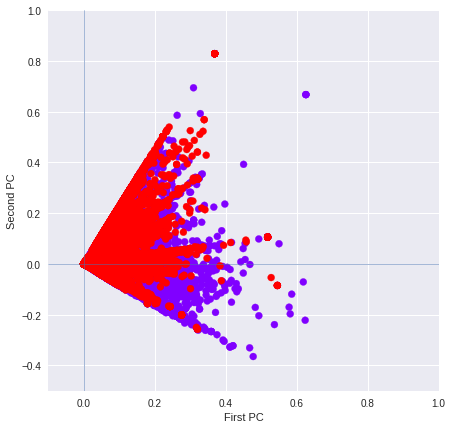

In [36]:
plt.figure(figsize=(7,7))
pc_1 = latent_semantic_analysis['component_1'].values
pc_2 = latent_semantic_analysis['component_2'].values

plt.scatter(pc_1, pc_2, c=df['class_numerical'], cmap='rainbow')

plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.axvline(linewidth=0.5)
plt.axhline(linewidth=0.5)
plt.xlim(-.1,1)
plt.ylim(-.5,1)

In [37]:
plt.figure(figsize=(6,6))
pc_1 = latent_semantic_analysis['component_1'].values
pc_2 = latent_semantic_analysis['component_2'].values

strings = df['cleaned_text'].values
for i, (x, y) in enumerate(zip(pc_1, pc_2)): 
    plt.text(x,y,strings[i][:10])

plt.scatter(pc_1, pc_2, c=df['class_numerical'], cmap='rainbow')

plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.axvline(linewidth=0.5)
plt.axhline(linewidth=0.5)
plt.xlim(-.1,1)
plt.ylim(-.1,1)

(-0.1, 1)

ValueError: 
$ $
^
Expected end of text (at char 0), (line:1, col:1)

(-0.3, 0.6)

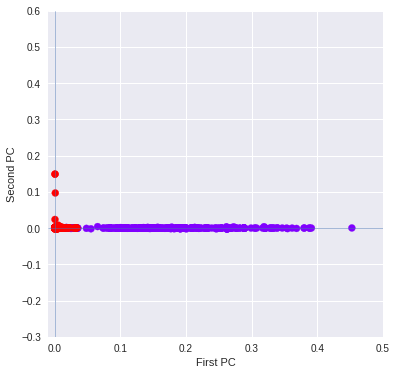

In [103]:
plt.figure(figsize=(6,6))
pc_1 = latent_semantic_analysis['component_1'].values
pc_2 = latent_semantic_analysis['component_2'].values

plt.scatter(pc_1, pc_2, c=df['class_numerical'], cmap='rainbow')

plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.axvline(linewidth=0.5)
plt.axhline(linewidth=0.5)
plt.xlim(-.01,.5)
plt.ylim(-.3,.6)

In [44]:
eg_mask = latent_semantic_analysis['class'] == 'EG'

In [45]:
latent_semantic_analysis[eg_mask][:5]

,component_1,component_2,cleaned_text,class
0,0.040851,-0.013632,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكره واللي أحنا فيه دلوقت كمان ح يفوت علينا ولا ندري,EG
1,0.040925,-0.027291,هي آراء آه بس أزاي أجويرو منتهي يعني أمال لو مكنش الهداف التاريخي للسيتي و كل موسم اقل عدد من الاهداف…,EG
2,0.006369,-0.001625,أنت صيني أزاي تقارن شادي بالخطيب ألي هو الوحيد ألي خد الكورة الذهبية من مصر وبشهادت الزملكاوي قبل الأ…,EG
3,0.020012,-0.007794,أزاي الناس كانت بتغرد في الخمسينات قبل إختراع تويتر,EG
4,0.067496,-0.044303,التوينز اللي معاها كل الحلو والوحش والمصايب والاكل والفشل مش عارفه من غيرك كنت هعيش أزاي ربنا يخليكي ليا ومش تويته توصفك,EG


In [40]:
gulf_mask = latent_semantic_analysis['class'] == 'GULF'

In [42]:
latent_semantic_analysis[gulf_mask][:5]

,component_1,component_2,cleaned_text,class
0,0.007562,-0.000259,على الاقل ارحم من ان تتعود على وجود احد ويغرقك اهتمام وحب ويغنيك عن الدنيا وبنص الطريج يخليك تعاني وتت…,GULF
1,0.001542,-0.000121,وحدة مكافحة الموز في الطريج الموز,GULF
2,0.001285,0.000157,اوك مسافة الطريج يايتلچ ‍️‍️‍️,GULF
3,0.018259,-0.006987,كلام جميل لكن وين التطبيق طلع قانون للخدم ونشر بالجريدة الرسمية من زمان وللحين احنا ناطرين ا…,GULF
4,0.071783,0.158170,الثالث علي الطريج طولي بالج اول الله️,GULF


In [47]:
latent_semantic_analysis[(latent_semantic_analysis['class'] == 'EG') 
                         & (latent_semantic_analysis.component_2 > .050)][:5]

,component_1,component_2,cleaned_text,class
14,0.098308,0.214051,الله اكبر رووووووووعه,EG
15,0.113691,0.103219,__ أنت غيرت المقام كدا أزاي الشيخ ماشاء الله,EG
55,0.133969,0.063809,سبحان الله ولا عرفنا أزاي هرب ولا مين ساعدة ودلوقتي ولا نعرف سلم نفسة ولا اتقبض علية كله,EG
147,0.063775,0.120697,ما شاء الله يا حبيبتي واخده عيون ماما مناخير ماما بق ماما,EG
148,0.062151,0.117917,ما شاء الله يا حبيبتي واخده عيون ماما مناخير ماما وبق ماما,EG


In [48]:
latent_semantic_analysis[(latent_semantic_analysis['class'] == 'GULF') 
                         & (latent_semantic_analysis.component_2 > .50)][:5]

,component_1,component_2,cleaned_text,class
4980,0.369124,0.829093,يَ الله (,GULF
4986,0.369124,0.829093,يَ الله,GULF
5234,0.241075,0.539617,الله الله وياك,GULF
9171,0.369124,0.829093,الله الله,GULF
9452,0.369124,0.829093,الله الله ️️,GULF


## LDA with stopwords

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df['cleaned_text'])
X_train_counts.shape

(179632, 219558)

In [54]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(192936, 223045)

In [35]:
svd_no_zero_rows = svd_matrix[~np.all(svd_matrix == 0, axis=1)]

In [38]:
svd_no_zero_rows

(178941, 50)

In [42]:
svd_mat_int = svd_no_zero_rows.astype(int)

In [ ]:
## GENSIM

In [48]:
#!pip install -U gensim

    100% |████████████████████████████████| 15.9MB 40kB/s  eta 0:00:01   60% |███████████████████▍            | 9.6MB 26.9MB/s eta 0:00:01    70% |██████████████████████▍         | 11.1MB 33.5MB/s eta 0:00:01    97% |███████████████████████████████ | 15.4MB 23.8MB/s eta 0:00:01
    100% |████████████████████████████████| 50.0MB 13kB/s  eta 0:00:01    32% |██████████▌                     | 16.5MB 35.0MB/s eta 0:00:01    78% |█████████████████████████       | 39.2MB 32.6MB/s eta 0:00:01
Requirement already up-to-date: six>=1.5.0 in /opt/conda/lib/python3.6/site-packages (from gensim)
    100% |████████████████████████████████| 17.0MB 39kB/s  eta 0:00:01   33% |██████████▉                     | 5.7MB 32.3MB/s eta 0:00:01
    100% |████████████████████████████████| 1.4MB 494kB/s eta 0:00:01
Requirement already up-to-date: requests in /opt/conda/lib/python3.6/site-packages (from smart-open>=1.2.1->gensim)
    100% |████████████████████████████████| 133kB 4.5MB/s eta 0:00:01
Requirement alre

In [98]:
import nltk

In [57]:
from nltk.text import Text  

In [79]:
from gensim import models, corpora

In [56]:
word_list = [word for line in df['cleaned_text'] for word in line.split()]

In [58]:
text_eda = Text(word_list)

In [59]:
text_eda[:3]

['أزاي', 'أقول', 'لك']

In [68]:
len(text_eda)

1838517

In [65]:
iabuelkhair_stopwords[:3]

['انها', 'اثناء', 'اجل']

In [69]:
len(iabuelkhair_stopwords)

1590

In [67]:
# remove stop words from tokens
text_eda_no_stops = [i for i in text_eda if not i in iabuelkhair_stopwords]

In [70]:
len(text_eda_no_stops)

1496265

Length of text_eda decreased by 342,252 due to 1,590 stop words. 

Get a list of words in every row

In [83]:
df["cleaned_text"] = df["cleaned_text"].map(lambda x: x.split(' '))

Passing df["cleaned_text"] to gensim's Dictionary:

In [86]:
dictionary = corpora.Dictionary(df["cleaned_text"])

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary(34127 unique tokens: ['أحنا', 'أزاي', 'أقول', 'الغيب', 'بكره']...)
INFO:gensim.corpora.dictionary:adding document #20000 to Dictionary(53319 unique tokens: ['أحنا', 'أزاي', 'أقول', 'الغيب', 'بكره']...)
INFO:gensim.corpora.dictionary:adding document #30000 to Dictionary(69263 unique tokens: ['أحنا', 'أزاي', 'أقول', 'الغيب', 'بكره']...)
INFO:gensim.corpora.dictionary:adding document #40000 to Dictionary(80421 unique tokens: ['أحنا', 'أزاي', 'أقول', 'الغيب', 'بكره']...)
INFO:gensim.corpora.dictionary:adding document #50000 to Dictionary(93339 unique tokens: ['أحنا', 'أزاي', 'أقول', 'الغيب', 'بكره']...)
INFO:gensim.corpora.dictionary:adding document #60000 to Dictionary(106599 unique tokens: ['أحنا', 'أزاي', 'أقول', 'الغيب', 'بكره']...)
INFO:gensim.corpora.dictionary:adding document #70000 to Dictionary(117032 unique tokens: ['أحنا', 'أزاي

Using filter_extremes method to eliminate the 5000 most frequent words

In [87]:
dictionary.filter_extremes(no_below=1, no_above=1, keep_n=5000)

INFO:gensim.corpora.dictionary:discarding 260679 tokens: [('والماضي', 6), ('يفوت', 9), ('آراء', 12), ('أجويرو', 2), ('أمال', 10), ('الاهداف…', 1), ('التاريخي', 24), ('الهداف', 8), ('للسيتي', 3), ('ألي', 7)]...
INFO:gensim.corpora.dictionary:keeping 5000 tokens which were in no less than 1 and no more than 179632 (=100.0%) documents
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary(5000 unique tokens: ['أحنا', 'أزاي', 'أقول', 'الغيب', 'بكره']...)


In [90]:
dictionary.compactify()

Using doc2bow method to get a bag of words representation (word_id, frequency) of corpus

In [100]:
corpus = [dictionary.doc2bow(text) for text in df["cleaned_text"]]

In [101]:
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


In [102]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.3333333333333333
INFO:gensim.models.ldamodel:using symmetric eta at 0.3333333333333333
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 3 topics, 20 passes over the supplied corpus of 179632 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.030*"في" + 0.020*"اللي" + 0.019*"ايه" + 0.018*"من" + 0.018*"يا" + 0.015*"ما" + 0.014*"على" + 0.013*"و" + 0.012*"ولا" + 0.011*"هو"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.048*"من" + 0.028*"في" + 0.024*"انا" + 0.013*"مش" + 0.013*"بقى" + 0.012*"بس" + 0.012*"كده" + 0.011*"ولا" + 0.011*"احنا" +

INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #22000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.070*"كدا" + 0.054*"و" + 0.020*"في" + 0.017*"اللي" + 0.016*"من" + 0.015*"ايه" + 0.014*"ما" + 0.014*"ف" + 0.012*"مش" + 0.012*"،"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.050*"من" + 0.032*"انا" + 0.024*"كدا" + 0.021*"في" + 0.016*"،" + 0.013*"كل" + 0.012*"دا" + 0.011*"مش" + 0.010*"ولا" + 0.010*"ف"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.061*"كدا" + 0.028*"يا" + 0.026*"مش" + 0.021*"بس" + 0.020*"والله" + 0.020*"لا" + 0.015*"انا" + 0.014*"ليه" + 0.013*"و" + 0.010*"الله"
INFO:gensim.models.ldamodel:topic diff=0.405097, rho=0.301511
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #24000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.087*"كدا" + 0.050*"و"

INFO:gensim.models.ldamodel:topic #2 (0.333): 0.045*"يا" + 0.028*"مش" + 0.028*"والله" + 0.025*"لا" + 0.023*"انا" + 0.021*"بس" + 0.020*"كدا" + 0.015*"الله" + 0.013*"ليه" + 0.012*"انت"
INFO:gensim.models.ldamodel:topic diff=0.212705, rho=0.218218
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #44000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.052*"و" + 0.021*"اللي" + 0.021*"ايه" + 0.019*"ف" + 0.018*"في" + 0.016*"كدا" + 0.015*"ما" + 0.014*"مش" + 0.013*"من" + 0.012*"لو"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.044*"من" + 0.036*"انا" + 0.018*"في" + 0.016*"كل" + 0.016*"حد" + 0.014*"ف" + 0.013*"حاجه" + 0.013*"ولا" + 0.012*"دا" + 0.012*"،"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.050*"يا" + 0.032*"والله" + 0.029*"مش" + 0.025*"لا" + 0.023*"انا" + 0.021*"بس" + 0.017*"كدا" + 0.015*"الله" + 0.012*"ليه" + 0.011*"انت"
INFO:gensim.models.ldamodel:topic diff=0.253794, rh

INFO:gensim.models.ldamodel:topic #0 (0.333): 0.057*"و" + 0.023*"في" + 0.023*"اللي" + 0.018*"ايه" + 0.017*"فى" + 0.016*"بتاع" + 0.014*"من" + 0.014*"ده" + 0.013*"مش" + 0.012*"على"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.051*"من" + 0.027*"انا" + 0.027*"في" + 0.015*"،" + 0.014*"كل" + 0.012*"حد" + 0.010*"مش" + 0.010*"ولا" + 0.010*"ان" + 0.010*"يوم"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.059*"يا" + 0.030*"مش" + 0.026*"والله" + 0.025*"لا" + 0.022*"انا" + 0.022*"بس" + 0.014*"ده" + 0.014*"ليه" + 0.012*"بقي" + 0.011*"الله"
INFO:gensim.models.ldamodel:topic diff=0.165765, rho=0.176777
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #66000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.055*"و" + 0.024*"في" + 0.022*"اللي" + 0.018*"ايه" + 0.016*"فى" + 0.014*"ف" + 0.014*"من" + 0.013*"بتاع" + 0.013*"ده" + 0.012*"مش"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.050*"من

INFO:gensim.models.ldamodel:topic diff=0.135999, rho=0.154303
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #86000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.042*"و" + 0.027*"اللي" + 0.023*"في" + 0.021*"ايه" + 0.015*"فى" + 0.015*"مش" + 0.013*"ما" + 0.013*"من" + 0.012*"ف" + 0.012*"ده"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.055*"من" + 0.032*"في" + 0.022*"انا" + 0.018*"كل" + 0.012*"حاجه" + 0.012*"،" + 0.011*"حد" + 0.011*"ان" + 0.010*"ولا" + 0.010*"يوم"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.057*"يا" + 0.030*"والله" + 0.028*"مش" + 0.024*"لا" + 0.023*"انا" + 0.021*"بس" + 0.020*"الله" + 0.011*"انت" + 0.010*"ربنا" + 0.010*"ليه"
INFO:gensim.models.ldamodel:topic diff=0.131432, rho=0.152499
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #88000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
I

INFO:gensim.models.ldamodel:topic #1 (0.333): 0.071*"من" + 0.033*"في" + 0.017*"كل" + 0.015*"لا" + 0.015*"،" + 0.011*"أن" + 0.010*"انا" + 0.010*"عن" + 0.010*"ان" + 0.007*"ولا"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.055*"يا" + 0.031*"الله" + 0.028*"لا" + 0.019*"والله" + 0.019*"️" + 0.017*"بس" + 0.016*"ما" + 0.015*"انا" + 0.013*""" + 0.011*"اللهم"
INFO:gensim.models.ldamodel:topic diff=0.140942, rho=0.137361
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #108000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.041*"و" + 0.025*"على" + 0.024*"في" + 0.023*"ما" + 0.020*"اللي" + 0.015*"من" + 0.009*"شي" + 0.009*"الي" + 0.008*"لو" + 0.007*"مع"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.068*"من" + 0.031*"في" + 0.017*"كل" + 0.015*"لا" + 0.013*"،" + 0.011*"انا" + 0.010*"أن" + 0.009*"ان" + 0.009*"عن" + 0.009*"مو"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.049*"يا" + 0.

INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #128000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.041*"و" + 0.027*"على" + 0.022*"في" + 0.018*"اللي" + 0.015*"من" + 0.015*"ما" + 0.013*"الي" + 0.011*"شي" + 0.010*"لو" + 0.007*"مع"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.068*"من" + 0.033*"في" + 0.020*"كل" + 0.020*"لا" + 0.018*"،" + 0.017*"أن" + 0.010*"مو" + 0.009*"عن" + 0.009*"لي" + 0.008*"ولا"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.048*"الله" + 0.030*"لا" + 0.024*"يا" + 0.019*"والله" + 0.018*"بس" + 0.015*"انت" + 0.014*"اذا" + 0.014*"️" + 0.013*"ما" + 0.013*"""
INFO:gensim.models.ldamodel:topic diff=0.084611, rho=0.125000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #130000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.038*"و" + 0.026*"على

INFO:gensim.models.ldamodel:topic #2 (0.333): 0.045*"الله" + 0.029*"لا" + 0.023*"والله" + 0.020*"يا" + 0.019*"انا" + 0.017*"️" + 0.017*"بس" + 0.016*"ما" + 0.014*"اذا" + 0.013*"انت"
INFO:gensim.models.ldamodel:topic diff=0.085733, rho=0.116248
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #150000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.039*"و" + 0.027*"على" + 0.026*"في" + 0.020*"اللي" + 0.016*"ما" + 0.015*"من" + 0.011*"لو" + 0.010*"شي" + 0.010*"الي" + 0.009*"مع"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.074*"من" + 0.037*"في" + 0.022*"،" + 0.019*"لا" + 0.016*"كل" + 0.011*"أن" + 0.010*"مو" + 0.009*"اي" + 0.009*"عن" + 0.008*"ولا"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.046*"الله" + 0.031*"لا" + 0.022*"والله" + 0.021*"يا" + 0.020*"انا" + 0.017*"بس" + 0.016*"ما" + 0.016*"️" + 0.013*"اذا" + 0.013*"انت"
INFO:gensim.models.ldamodel:topic diff=0.133149, rho=0.

INFO:gensim.models.ldamodel:topic #1 (0.333): 0.071*"من" + 0.043*"في" + 0.020*"،" + 0.018*"لا" + 0.016*"كل" + 0.014*"أن" + 0.011*"…" + 0.009*"عن" + 0.008*"ولا" + 0.007*"لي"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.061*"الله" + 0.036*"يا" + 0.023*"لا" + 0.017*"والله" + 0.016*"ما" + 0.016*"يارب" + 0.014*"اللهم" + 0.014*"️" + 0.012*"انا" + 0.012*"على"
INFO:gensim.models.ldamodel:topic diff=0.140180, rho=0.108465
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #172000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.032*"في" + 0.032*"و" + 0.031*"على" + 0.016*"من" + 0.015*"ما" + 0.013*"اللي" + 0.011*"…" + 0.011*"مع" + 0.010*"قطر" + 0.008*"هذا"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.071*"من" + 0.042*"في" + 0.022*"،" + 0.020*"لا" + 0.016*"كل" + 0.016*"أن" + 0.012*"…" + 0.009*"عن" + 0.008*"ولا" + 0.007*"لي"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.060*"الله" +

INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #12000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.046*"و" + 0.030*"في" + 0.022*"اللي" + 0.022*"على" + 0.017*"ما" + 0.015*"من" + 0.010*"لو" + 0.010*"هو" + 0.009*"كان" + 0.009*"فيه"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.066*"من" + 0.049*"،" + 0.037*"في" + 0.019*"لا" + 0.017*"أن" + 0.017*"كل" + 0.010*"…" + 0.009*"ولا" + 0.008*"عن" + 0.007*"يوم"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.040*"يا" + 0.037*"الله" + 0.020*"لا" + 0.018*"مش" + 0.017*"بس" + 0.015*"انا" + 0.015*"ما" + 0.013*"فـ" + 0.012*"والله" + 0.012*"""
INFO:gensim.models.ldamodel:topic diff=0.123120, rho=0.104362
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #14000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.046*"و" + 0.030*"في" 

INFO:gensim.models.ldamodel:topic #2 (0.333): 0.075*"كدا" + 0.038*"يا" + 0.031*"انا" + 0.027*"مش" + 0.022*"بس" + 0.021*"الله" + 0.021*"والله" + 0.018*"لا" + 0.012*"انت" + 0.012*"ليه"
INFO:gensim.models.ldamodel:topic diff=0.077698, rho=0.104362
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #34000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.054*"و" + 0.026*"في" + 0.024*"اللي" + 0.015*"ف" + 0.014*"ايه" + 0.014*"من" + 0.014*"كدا" + 0.013*"ما" + 0.013*"حد" + 0.012*"هو"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.065*"من" + 0.035*"في" + 0.035*"،" + 0.018*"كل" + 0.017*"لا" + 0.010*"ولا" + 0.010*"أن" + 0.010*"يوم" + 0.007*"عن" + 0.007*"ان"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.069*"كدا" + 0.040*"يا" + 0.032*"انا" + 0.027*"مش" + 0.023*"والله" + 0.022*"بس" + 0.020*"الله" + 0.018*"لا" + 0.012*"انت" + 0.012*"ليه"
INFO:gensim.models.ldamodel:topic diff=0.072672, rho

INFO:gensim.models.ldamodel:topic #0 (0.333): 0.053*"و" + 0.028*"بتاع" + 0.026*"اللي" + 0.023*"في" + 0.016*"ايه" + 0.015*"حد" + 0.015*"ف" + 0.014*"مش" + 0.013*"من" + 0.011*"ما"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.062*"من" + 0.033*"في" + 0.028*"،" + 0.020*"كل" + 0.016*"لا" + 0.011*"يوم" + 0.011*"ولا" + 0.009*"(" + 0.008*"ان" + 0.007*"أن"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.047*"يا" + 0.041*"انا" + 0.030*"مش" + 0.028*"كدا" + 0.027*"والله" + 0.021*"بس" + 0.017*"لا" + 0.017*"الله" + 0.014*"انت" + 0.012*"ليه"
INFO:gensim.models.ldamodel:topic diff=0.073803, rho=0.104362
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #56000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.060*"و" + 0.027*"اللي" + 0.026*"بتاع" + 0.024*"في" + 0.015*"ايه" + 0.014*"حد" + 0.014*"مش" + 0.013*"ف" + 0.012*"من" + 0.011*"ما"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.062*"من" +

INFO:gensim.models.ldamodel:topic diff=0.083694, rho=0.104362
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #76000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.042*"و" + 0.024*"في" + 0.021*"اللي" + 0.018*"فى" + 0.017*"ايه" + 0.015*"مش" + 0.013*"من" + 0.013*"ف" + 0.012*"ده" + 0.012*"لما"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.065*"من" + 0.038*"في" + 0.021*"،" + 0.019*"كل" + 0.017*"لا" + 0.011*"يوم" + 0.010*"ولا" + 0.010*"ان" + 0.008*"عن" + 0.007*"أن"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.051*"يا" + 0.039*"انا" + 0.030*"مش" + 0.022*"والله" + 0.021*"بس" + 0.020*"الله" + 0.018*"لا" + 0.012*"انت" + 0.012*"ربنا" + 0.011*"ليه"
INFO:gensim.models.ldamodel:topic diff=0.099173, rho=0.104362
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #78000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INF

INFO:gensim.models.ldamodel:topic #1 (0.333): 0.066*"من" + 0.035*"في" + 0.025*"،" + 0.023*"لا" + 0.020*"كل" + 0.010*"ما" + 0.010*"ولا" + 0.010*"يوم" + 0.009*"الله" + 0.008*"عن"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.055*"يا" + 0.035*"انا" + 0.024*"مش" + 0.024*"الله" + 0.023*"والله" + 0.021*"بس" + 0.018*"لا" + 0.012*"انت" + 0.011*"يارب" + 0.011*"""
INFO:gensim.models.ldamodel:topic diff=0.113469, rho=0.104362
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #98000/179632
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 179632 documents
INFO:gensim.models.ldamodel:topic #0 (0.333): 0.049*"و" + 0.026*"اللي" + 0.024*"في" + 0.015*"على" + 0.013*"ايه" + 0.013*"من" + 0.012*"مش" + 0.012*"ما" + 0.010*"فى" + 0.010*"لو"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.069*"من" + 0.036*"في" + 0.025*"،" + 0.023*"لا" + 0.020*"كل" + 0.010*"ما" + 0.009*"ولا" + 0.009*"يوم" + 0.009*"الله" + 0.009*"أن"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.057*"يا"

KeyboardInterrupt: 

In [94]:
dictionary.doc2bow(dictionary, allow_update=True, return_missing=False)

TypeError: decoding to str: need a bytes-like object, int found

In [ ]:
class MyCorpus(object):
    def __iter__(self):
        for line in open('datasets/mycorpus.txt'):
            # assume there's one document per line, tokens separated by whitespace
            yield dictionary.doc2bow(line.lower().split())

In [ ]:
corpora.Dictionary(df["cleaned_text"])

In [92]:
gensim.(dictionary, allow_update=True, return_missing=False)

AttributeError: module 'gensim' has no attribute 'doc2bow'

In [ ]:
# add a new doc (tokens) to this dictionary and update it."Same tokens to the same ids and new tokens to new ids".
# dict2 = corpora.Dictionary(moreDocs)
# dict1.merge_with(dict2)

In [76]:
new_vec = dictionary.doc2bow(text_eda_no_stops)
print(new_vec)  # the word "interaction" does not appear in the dictionary and is ignored
[(0, 1), (1, 1)]

NameError: name 'dictionary' is not defined

In [75]:
tfidf = models.TfidfModel(text_eda_no_stops)

INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0


ValueError: not enough values to unpack (expected 2, got 1)

In [72]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = Dictionary(text_eda_no_stops)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in text_eda_no_stops]

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=2, id2word = dictionary, passes=20)

NameError: name 'Dictionary' is not defined

In [53]:
tfidf = models.TfidfModel(df.cleaned_text)

INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
iabuelkhair_stopwords

In [ ]:
corpus = gensim.matutils.Sparse2Corpus(scipy_sparse_matrix)

In [46]:
model = lda.LDA(n_topics=3, n_iter=2, random_state=1)

model.fit(svd_mat_int)

topic_word = model.topic_word_
n_top_words = 3

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

INFO:lda:n_documents: 178941
INFO:lda:vocab_size: 50
INFO:lda:n_words: 0
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2
INFO:lda:<0> log likelihood: 0
INFO:lda:<1> log likelihood: 0


NameError: name 'vocab' is not defined